In [25]:
#8.3.2 배치 정규화와 드롭아웃

In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # GPU 이용 가능 시 CUDA 모드 실행

In [27]:
trainset = torchvision.datasets.FashionMNIST(root='data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor()) # 토치비전 데이터 셋 다운

100%|██████████| 26421880/26421880 [00:14<00:00, 1772319.91it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 103902.45it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1399286.47it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5123938.54it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [28]:
batch_size = 4 # 이미지 확인을 위한 512 배치 크기 선언

In [29]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True) # 학습 데이터를 가져와서 섞음

In [30]:
dataiter = iter(trainloader)
images, labels = next(dataiter) # 실행 할때마다 다음 배치로 넘어감

print(images.shape) # 배치 첫번째 데이터 크기 확인
print(images[0].shape) # 배치의 첫번째 데이터 크기 확인
print(labels[0].item()) # 배치의 첫번째 데이터 값 확인

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
3


In [31]:
def imshow(img, title): # 이미지 확인 용 함수 선언
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [32]:
def show_batch_images(dataloader): # 배치 크기 단위의 데이터를 imshow 함수에 넣어 반복하는 함수 선언
    images, labels = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])
    
    return images, labels

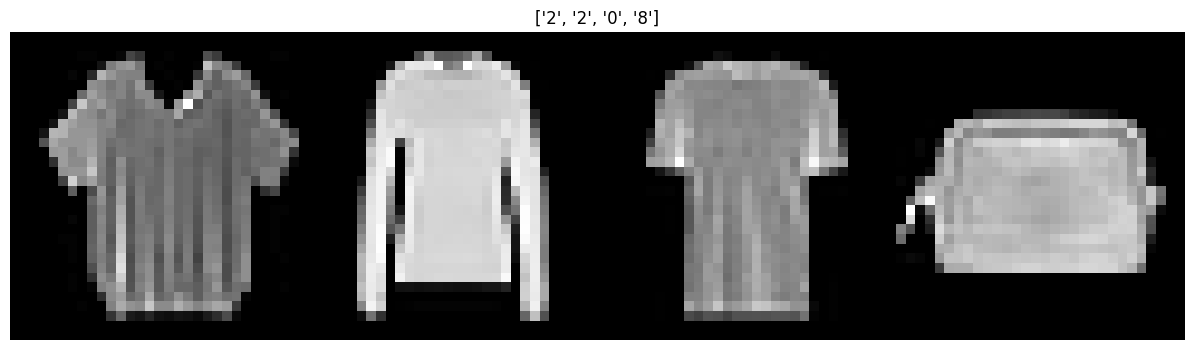

In [33]:
images, labels = show_batch_images(trainloader)

In [34]:
class NormalNet(nn.Module): # 기존 일반적인 신경망 모델 구성
    def __init__(self): 
        super(NormalNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10) # 10개의 아웃풋
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [35]:
class BNNet(nn.Module): # 배치 정규화가 적용된 모델 구성
    def __init__(self): 
        super(BNNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48), # 완전 연결망 or 합성곱층 뒤 
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24), # 활성화 함수 앞
            nn.ReLU(),
            nn.Linear(24, 10) # 10개의 아웃풋
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [36]:
model = NormalNet().to(device)
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [37]:
model_bn = BNNet().to(device)
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [38]:
batch_size = 512 # 훈련을 위한 512 배치 크기 선언

In [39]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True) # 배치 크기의 데이터 로드 후 섞음

In [40]:
loss_fn = nn.CrossEntropyLoss().to(device) # 손실 함수를 CrossEntropyLoss로 지정
opt = optim.SGD(model.parameters(), lr=0.01) # 최적화 함수를 SGD로 지정
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

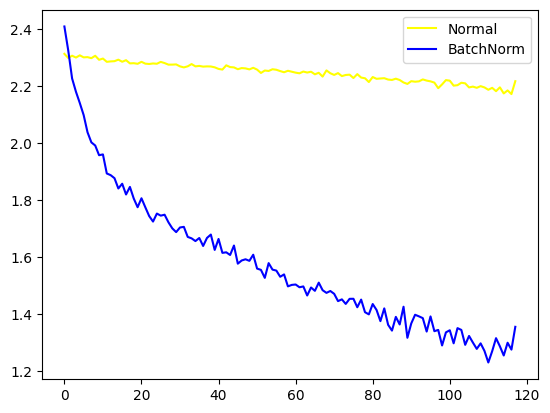

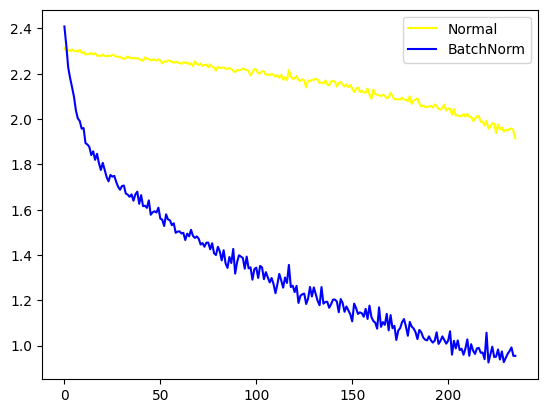

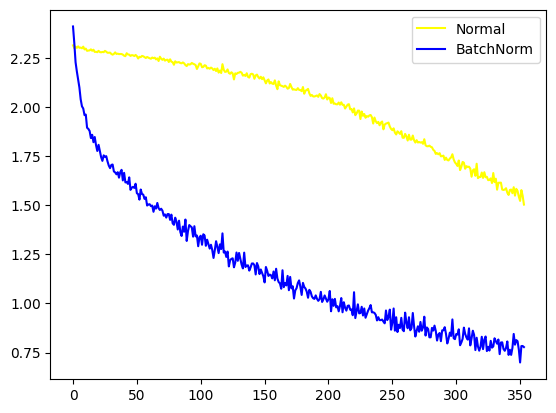

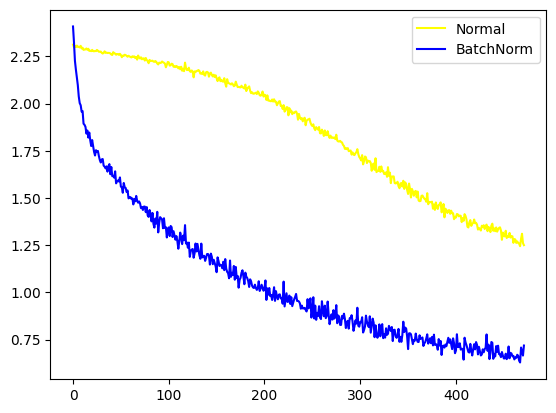

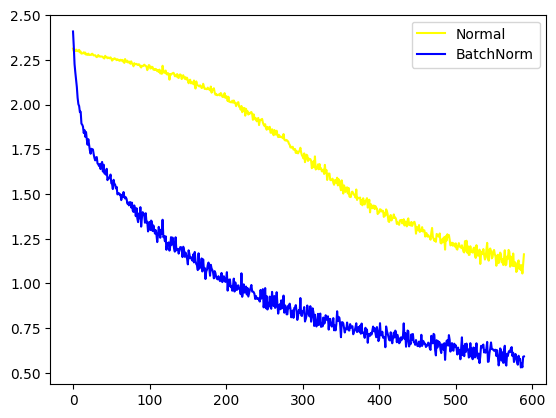

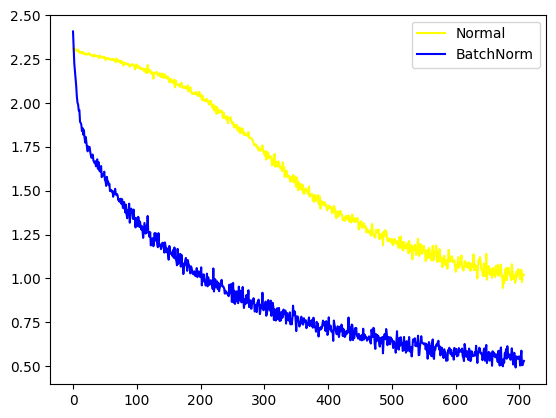

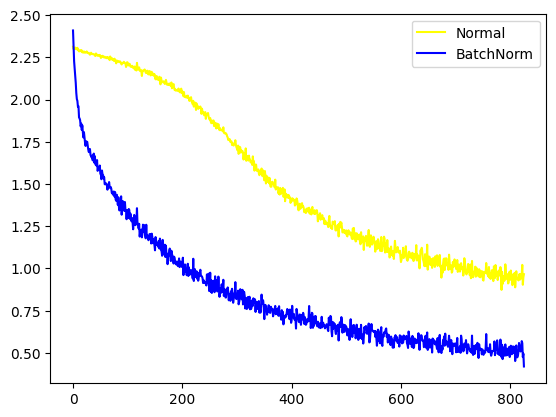

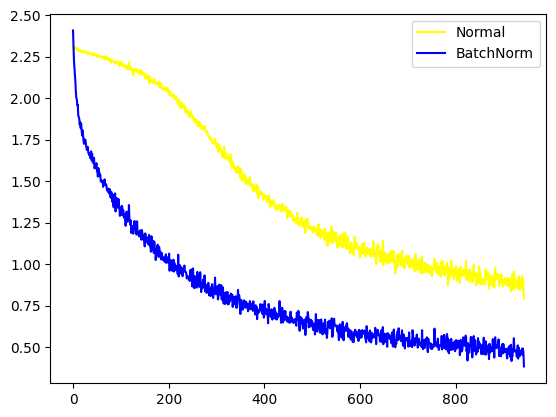

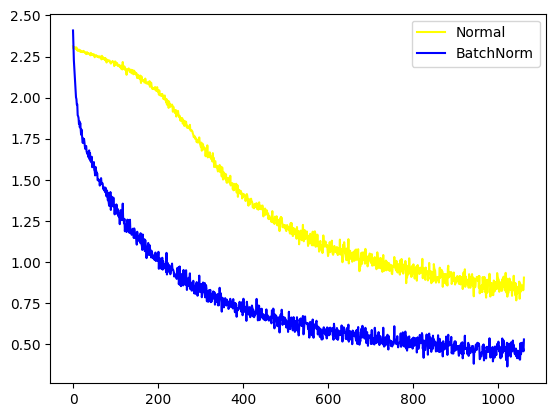

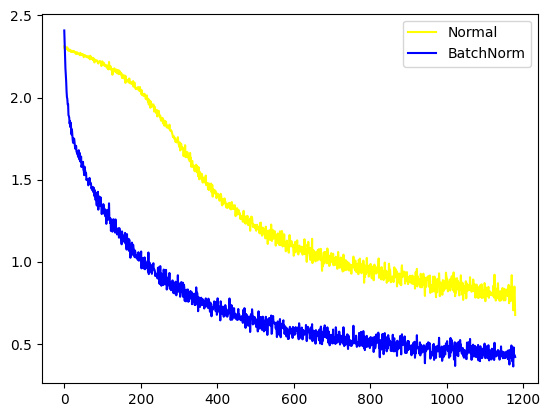

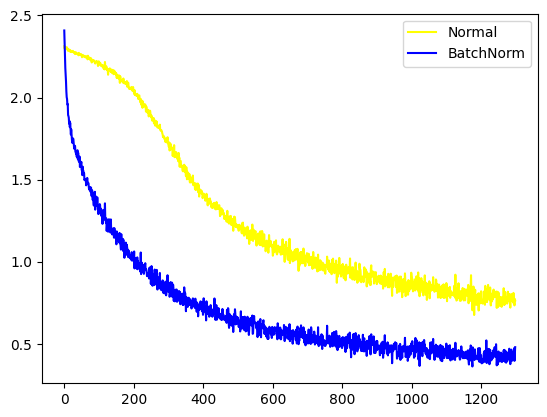

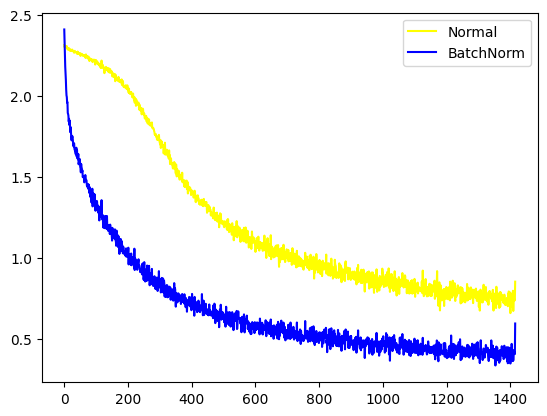

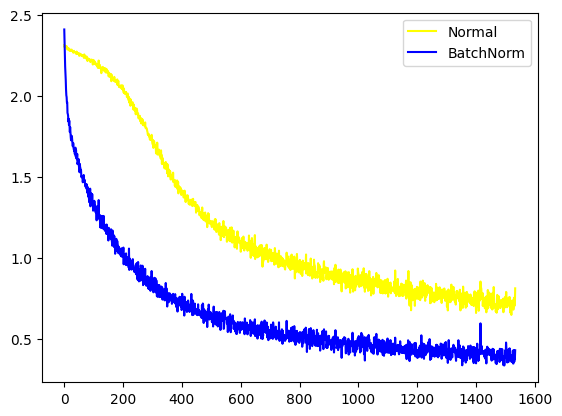

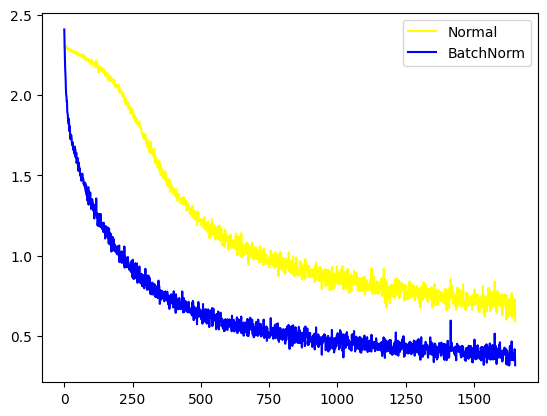

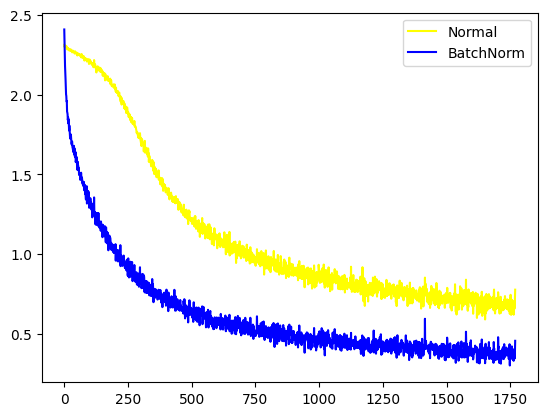

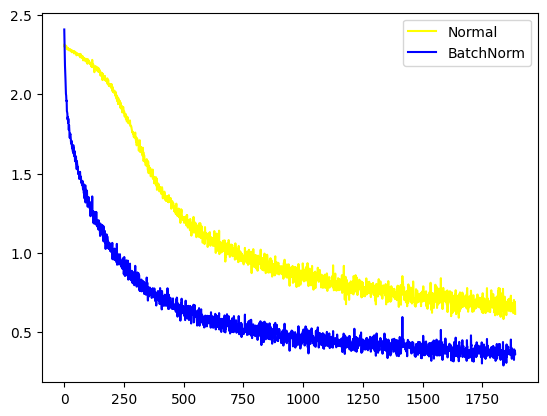

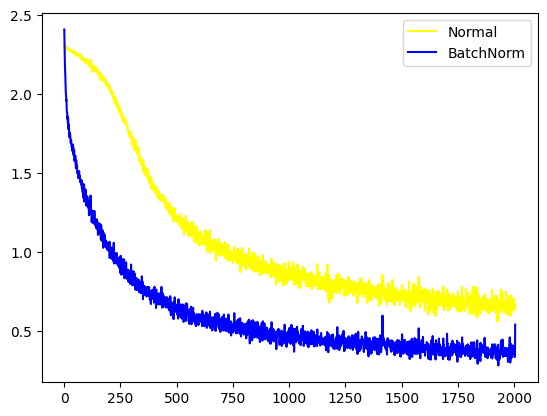

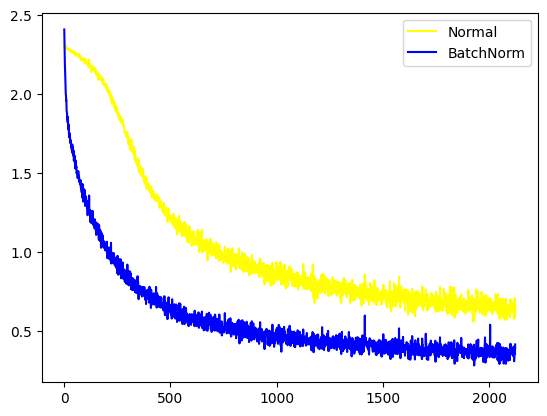

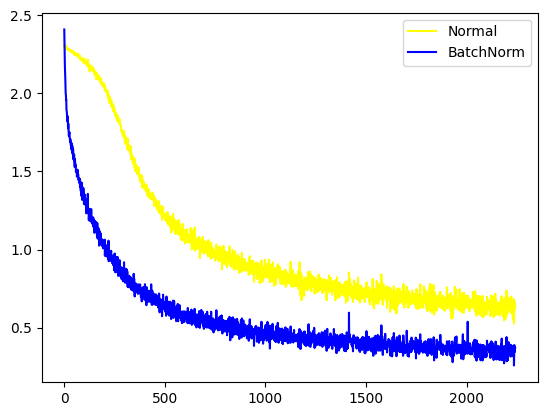

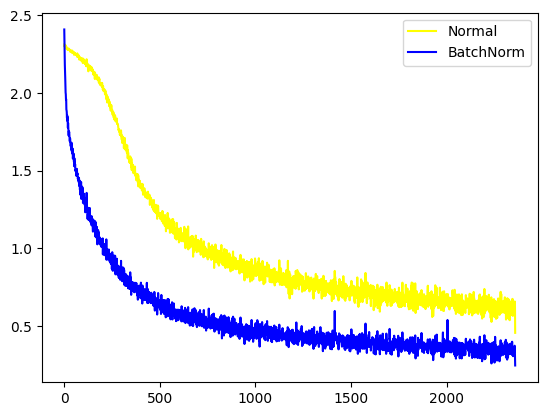

In [41]:
loss_arr = [] # Loss 값이 저장될 배열
loss_bn_arr = [] 
max_epochs = 20

for epoch in range(max_epochs): # 매 epoch마다 훈련을 하면서 Loss가 어떻게 변하는지 확인
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(inputs).to(device)        
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
           
    plt.plot(loss_arr, 'yellow', label='Normal')
    plt.plot(loss_bn_arr, 'blue', label='BatchNorm')    
    plt.legend()
    plt.show()

# 중간중간 정규화 한 것이 Loss가 빠르게 감소함. (학습 결과가 좋음)

In [42]:
N = 50 
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))
#x_train, y_train= x_train.to(device), y_train.to(device)
x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))
#x_test, y_test = x_test.to(device), y_test.to(device)

# 50개 씩의 2축 랜덤 데이터 구성

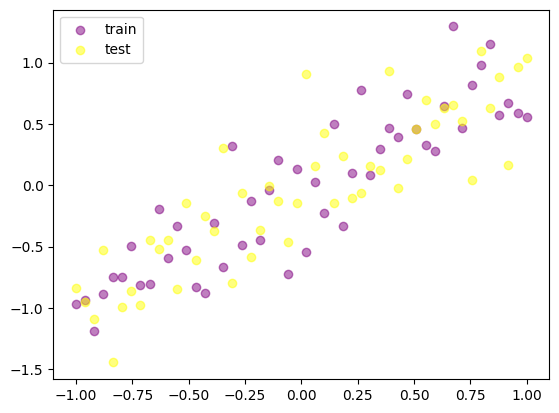

In [43]:
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

# 데이터 시각화

In [44]:
N_h = 100
model = torch.nn.Sequential( # 일반 모델 구성
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

model_dropout = torch.nn.Sequential( # 드롭아웃 모델 구성
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

In [45]:
opt = torch.optim.Adam(model.parameters(), lr=0.01) # 최적화 함수 지정 
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01) 
loss_fn = torch.nn.MSELoss().to(device) # 손실 함수 지정 

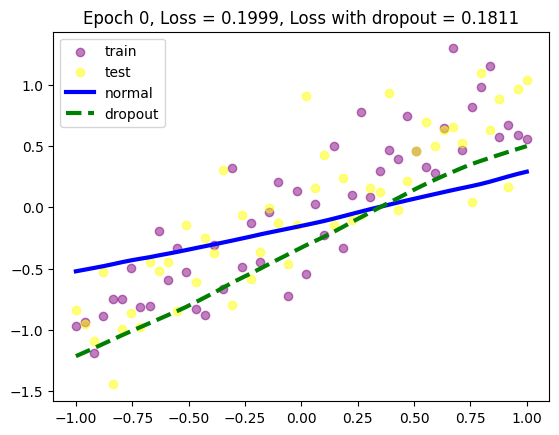

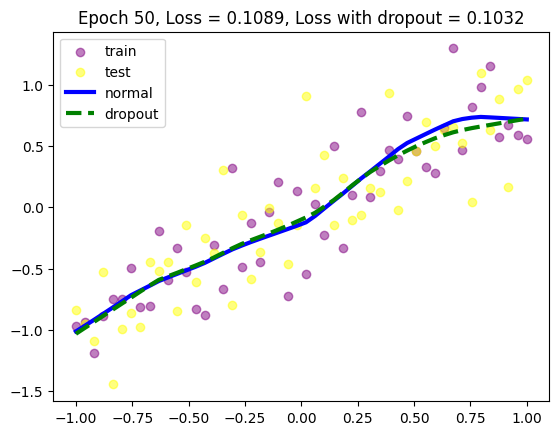

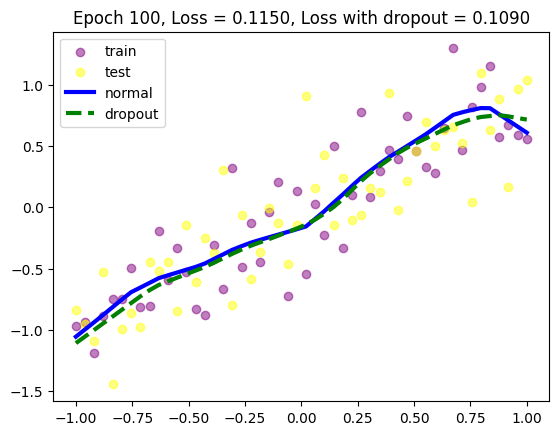

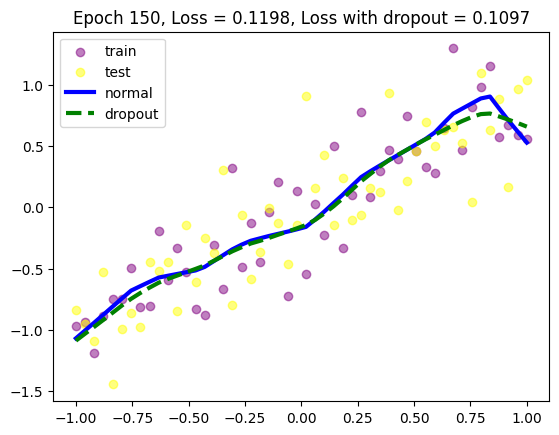

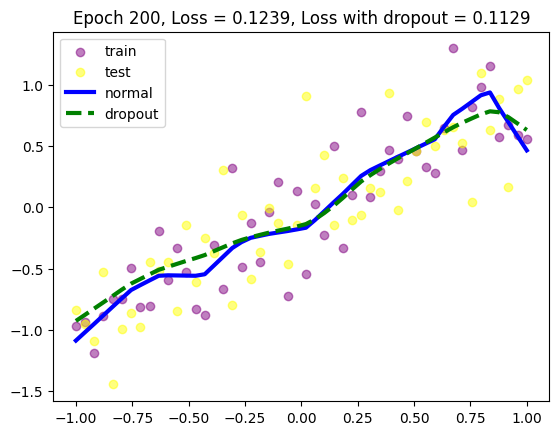

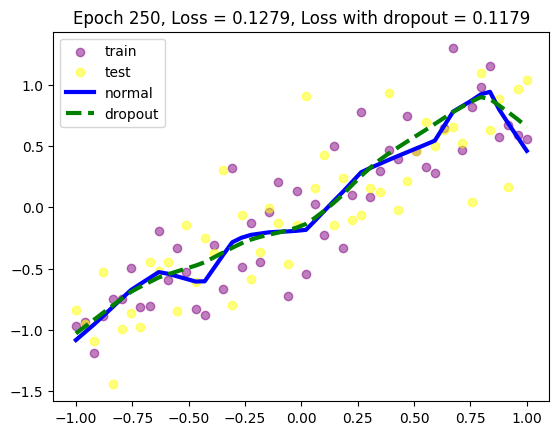

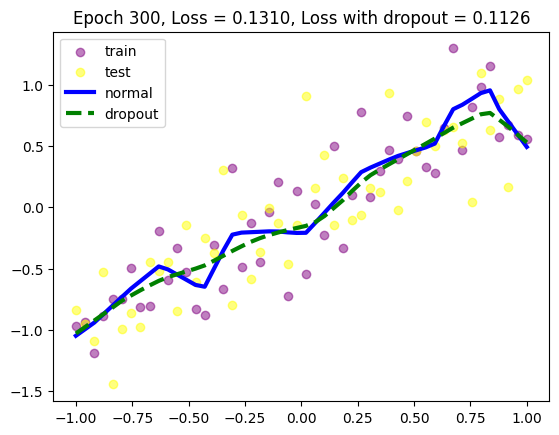

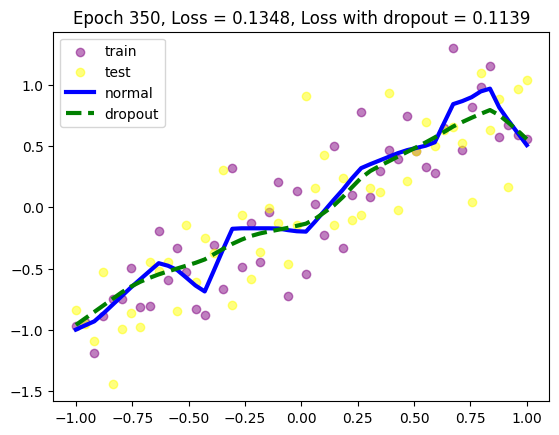

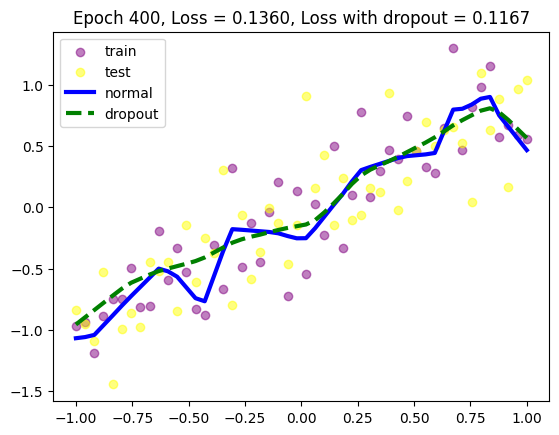

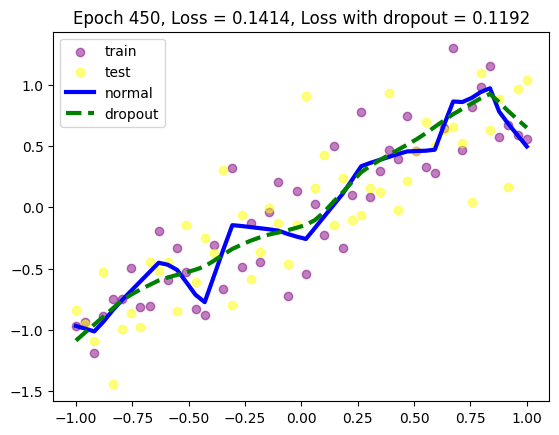

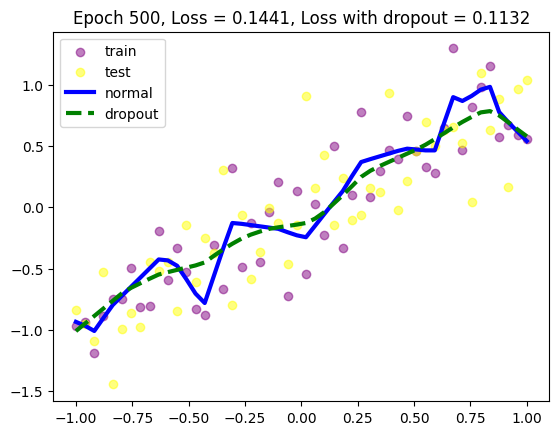

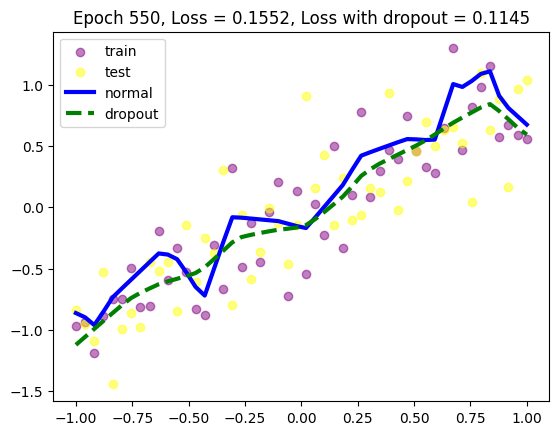

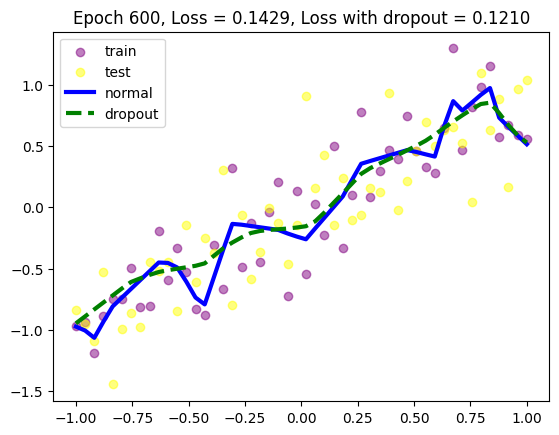

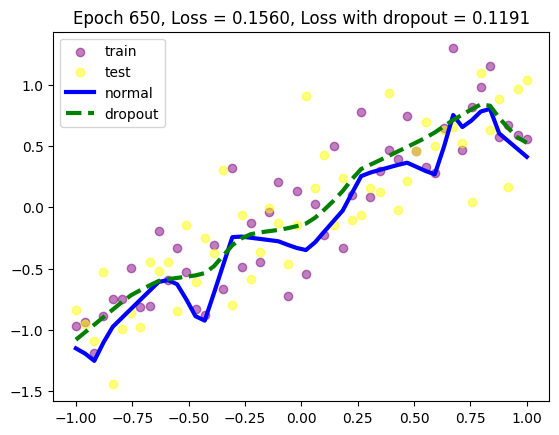

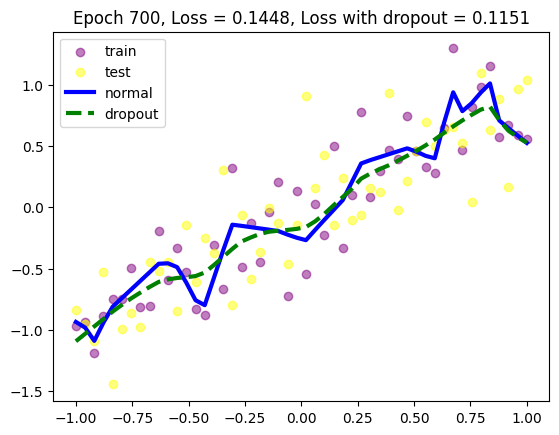

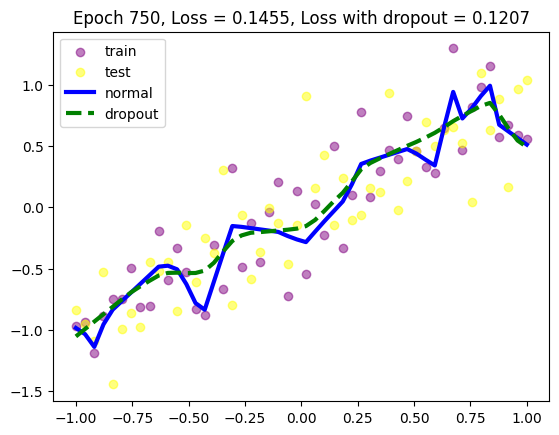

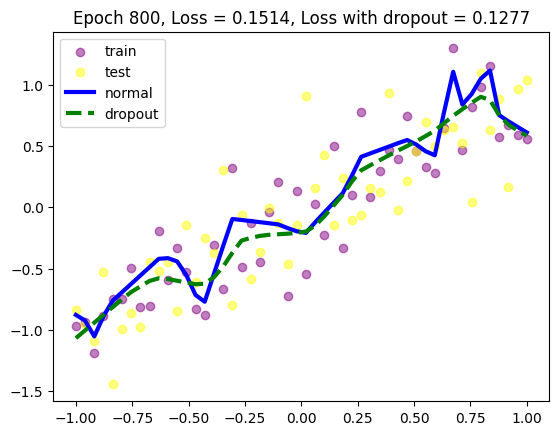

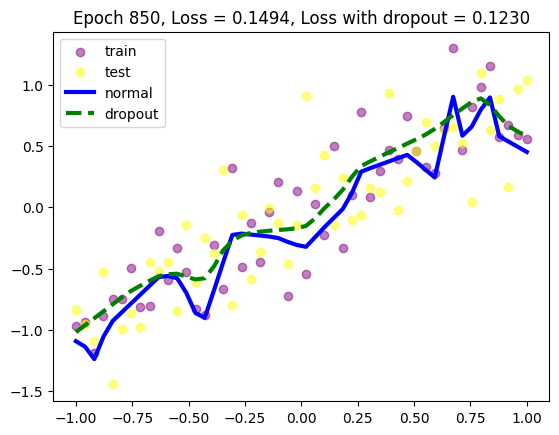

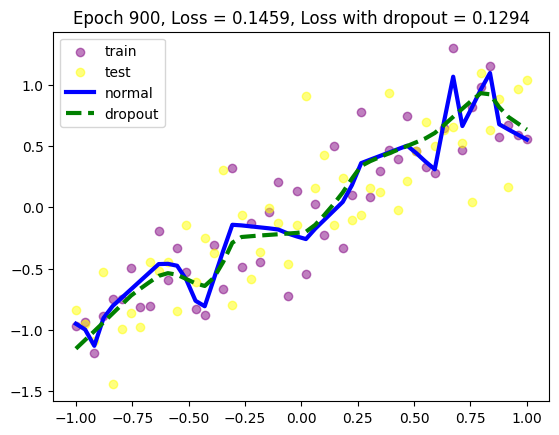

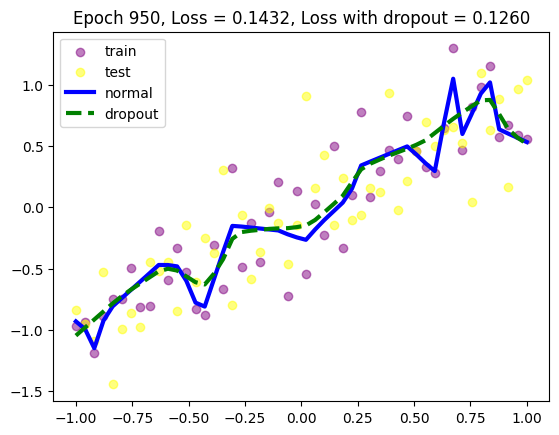

In [46]:
max_epochs = 1000
for epoch in range(max_epochs): # 1000번의 epoch 훈련
    pred = model(x_train)
    loss = loss_fn(pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pred_dropout = model_dropout(x_train)
    loss_dropout = loss_fn(pred_dropout, y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()    
    
    if epoch % 50 == 0: # 50 epoch 마다 그래프 생성
        model.eval()
        model_dropout.eval()
        
        test_pred = model(x_test)
        test_loss = loss_fn(test_pred, y_test)
        
        test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = loss_fn(test_pred_dropout, y_test)
        
        plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='normal')
        plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3,  label='dropout')
        
        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout))
        plt.legend()
        model.train()
        model_dropout.train()        
        plt.pause(0.05)

# 그래프에서 드롭아웃을 적용한 쪽에서 과적합이 감소함을 보임. (학습 결과가 좋음)